<a href="https://www.kaggle.com/code/erayyglr/customer-segmentation-with-k-means?scriptVersionId=222879464" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 🛒 Introduction  

Customer segmentation helps businesses identify different customer groups and develop more effective marketing strategies. In this project, we will use the **K-Means clustering algorithm** to segment customers based on their purchasing behavior.  

### 📌 Objective  
- Analyze customers using **RFM (Recency, Frequency, Monetary) metrics**  
- Apply the **K-Means algorithm** to identify customer segments  
- Compare K-Means results with rule-based segmentation using RFM metrics  

### 📊 Dataset Used  
- **Online Retail II**: Contains **online sales transactions** of a UK-based retail company between **2009 and 2011**.  
- **Features (Columns)**:  
  - **InvoiceNo**: Invoice number (If it starts with "C", the transaction is canceled)  
  - **StockCode**: Unique product code  
  - **Description**: Product name  
  - **Quantity**: Number of products sold  
  - **InvoiceDate**: Date of transaction  
  - **UnitPrice**: Price of the product (£)  
  - **CustomerID**: Unique customer identifier  
  - **Country**: Customer’s country  

### 🔍 Project Steps  
✅ Clean the data by handling missing and incorrect values  
✅ Calculate **RFM metrics** for customer segmentation  
✅ Apply **K-Means clustering** to group customers    

This project aims to develop an effective **data-driven customer segmentation approach** to better understand customer behavior and improve business decisions. 🚀  


# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# EDA

## Loading Dataset

In [2]:
df = pd.read_excel('/kaggle/input/online-retail1/online_retail_II-230817-120704.xlsx')

## General Overview of the Dataset

In [3]:
def check_data(dataframe, head=5):
    print("##### SHAPE #####")
    print(dataframe.shape)
    print("##### INFO #####")
    print(dataframe.info())
    print("##### DESCRIBE #####")
    print(dataframe.describe([0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99]))
    print("##### NA VALUES #####")
    print(dataframe.isnull().sum())
    print("##### FIRST {} ROWS #####".format(head))
    print(dataframe.head(head))

In [4]:
def select_country(dataframe, country):
    new_dataframe = dataframe.loc[dataframe["Country"] == country]
    return new_dataframe

## Null and Outlier Analysis

In [5]:
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [6]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    iqr = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    return low_limit, up_limit

In [7]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [8]:
check_data(df)

##### SHAPE #####
(525461, 8)
##### INFO #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None
##### DESCRIBE #####
            Quantity                    InvoiceDate          Price  \
count  525461.000000                         525461  525461.000000   
mean       10.337667  2010-06-28 11:37:36.845017856       4.688834   
min     -9600.000000     

## Data Cleaning & Filtering

In [9]:
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[(df["Quantity"] > 0)]
df.dropna(inplace=True)

If Invoice starts with C, it means that the transaction has been canceled so we extract it from data

In [10]:
df.describe([0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,Quantity,InvoiceDate,Price,Customer ID
count,407695.000000,407695,407695.000000,407695.000000
mean,13.586686,2010-07-01 10:10:10.782178048,3.294188,15368.504107
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000
1%,1.000000,2009-12-02 15:10:00,0.290000,12435.000000
10%,1.000000,2010-01-19 11:01:00,0.650000,13044.000000
25%,2.000000,2010-03-26 14:01:00,1.250000,13997.000000
50%,5.000000,2010-07-09 15:46:00,1.950000,15321.000000
75%,12.000000,2010-10-14 17:09:00,3.750000,16812.000000
90%,24.000000,2010-11-18 10:37:00,6.750000,17706.000000
95%,36.000000,2010-11-28 13:53:00,8.500000,17913.000000


In [11]:
df[df["Price"] == 0]["StockCode"].unique()

array([22076, 48185, 'M', 22065, 22142, 85042, 21143, 79320, 22355, 21533,
       'TEST001', 21662, 22459, 22458, 22376, 21765, 20914, 22423, 22690,
       22472, 22202, '46000M', 22218, 22630, 22121, 21843, 22624, 22846,
       22845, 22841], dtype=object)

In [12]:
df = df[df["StockCode"] != "M"]  # extracting some unnecessary data

In [13]:
invalid_codes = df[df["StockCode"].astype(str).str.contains(r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()
invalid_codes

['POST', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'ADJUST2']

In [14]:
df[df["StockCode"].isin(invalid_codes)].groupby(["StockCode"]).agg({"Invoice":"nunique",
                                                                    "Quantity":"sum",
                                                                    "Price":"sum",
                                                                    "Customer ID":"nunique"})

,Invoice,Quantity,Price,Customer ID
StockCode,,,,
ADJUST,32,32,3538.520,25
ADJUST2,3,3,731.050,3
BANK CHARGES,20,20,300.000,12
PADS,14,14,0.014,12
POST,738,2212,19964.830,230
TEST001,11,60,40.500,4
TEST002,1,1,1.000,1


In [15]:
df = df[~df["StockCode"].isin(invalid_codes)].reset_index(drop=True)

In [16]:
check_data(df)

##### SHAPE #####
(406450, 8)
##### INFO #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406450 entries, 0 to 406449
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406450 non-null  object        
 1   StockCode    406450 non-null  object        
 2   Description  406450 non-null  object        
 3   Quantity     406450 non-null  int64         
 4   InvoiceDate  406450 non-null  datetime64[ns]
 5   Price        406450 non-null  float64       
 6   Customer ID  406450 non-null  float64       
 7   Country      406450 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB
None
##### DESCRIBE #####
            Quantity                    InvoiceDate          Price  \
count  406450.000000                         406450  406450.000000   
mean       13.616068  2010-07-01 10:28:27.142083840       3.006186   
min         1.000000     

In [17]:
df["TotalPrice"] = df["Price"] * df["Quantity"]

In [18]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
406445,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90
406446,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
406447,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
406448,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50


In [19]:
max_invoice_date = df["InvoiceDate"].max()
today_date = (max_invoice_date + dt.timedelta(days=2))

In [20]:
rfm = df.groupby("Customer ID").agg({"InvoiceDate": lambda date: (today_date - date.max()).days,#Recency
                                     "Invoice":"nunique",#frequency
                                     "TotalPrice":"sum"})#monetary

In [21]:
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,166,2,169.36
12347.0,4,2,1323.32
12348.0,75,1,221.16
12349.0,44,2,2221.14
12351.0,12,1,300.93


In [22]:
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]
rfm

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,166,2,169.36
12347.0,4,2,1323.32
12348.0,75,1,221.16
12349.0,44,2,2221.14
12351.0,12,1,300.93
...,...,...,...
18283.0,19,6,641.77
18284.0,68,1,461.68
18285.0,297,1,427.00


In [23]:
for col in rfm.columns:
    print(col, check_outlier(rfm, col))

Recency False
Frequency True
Monetary True


In [24]:
for col in rfm.columns:
    replace_with_thresholds(rfm, col)

## Distributions

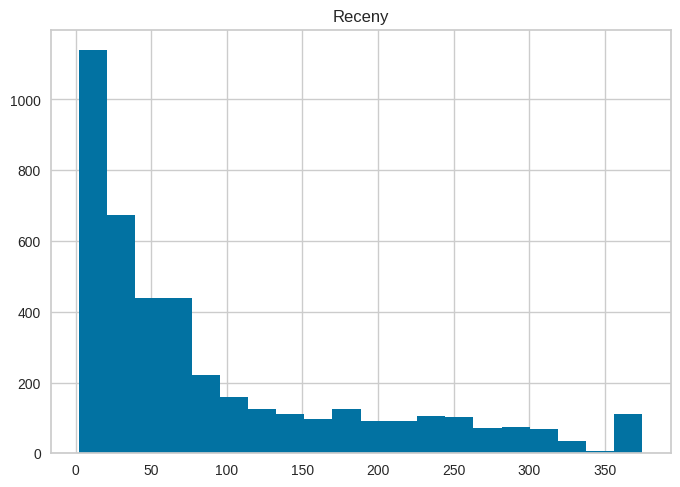

In [25]:
rfm["Recency"].hist(bins=20)
plt.title("Receny")
plt.show()

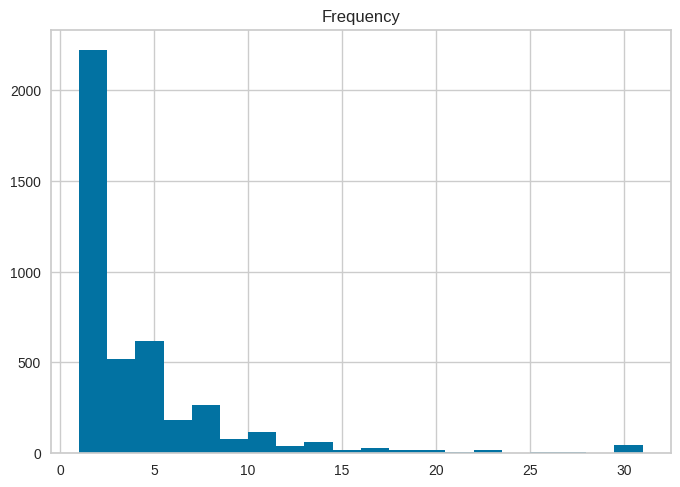

In [26]:
rfm["Frequency"].hist(bins=20)
plt.title("Frequency")
plt.show()

### Log Transformation

In [27]:
for col in ["Recency", "Frequency"]:
    rfm[f"LOG_{col}"] = np.log1p(rfm[col])
rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency
Customer ID,,,,,
12346.0,166.0,2,169.36,5.117994,1.098612
12347.0,4.0,2,1323.32,1.609438,1.098612
12348.0,75.0,1,221.16,4.330733,0.693147
12349.0,44.0,2,2221.14,3.806662,1.098612
12351.0,12.0,1,300.93,2.564949,0.693147


## Data Standardization

In [28]:
sc = StandardScaler()
sc.fit(rfm[["LOG_Recency", "LOG_Frequency"]])
scaled_rf = sc.transform(rfm[["LOG_Recency", "LOG_Frequency"]])

In [29]:
scaled_df = pd.DataFrame(index=rfm.index, columns=["LOG_Recency", "LOG_Frequency"], data=scaled_rf)
scaled_df

,LOG_Recency,LOG_Frequency
Customer ID,,
12346.0,0.986476,-0.396575
12347.0,-1.850271,-0.396575
12348.0,0.349958,-1.004394
12349.0,-0.073765,-0.396575
12351.0,-1.077718,-1.004394
...,...,...
18283.0,-0.729420,0.873581
18284.0,0.271833,-1.004394
18285.0,1.454691,-1.004394


# Model Training & Evaluation

## Kmeans with elbow method

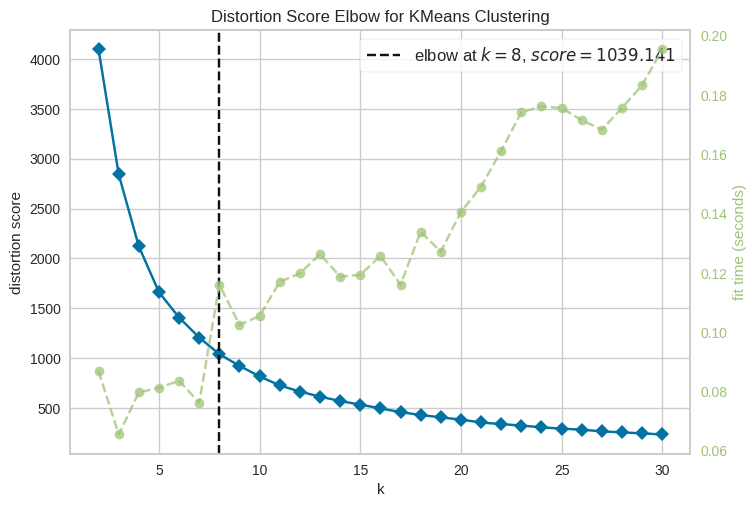

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=30)
elbow.fit(scaled_df)
elbow.show()

In [31]:
k_ = elbow.elbow_value_
k_

8

In [32]:
k_means = KMeans(n_clusters=k_, random_state=99).fit(scaled_df)
segments = k_means.labels_

In [33]:
rfm["Kmeans_Segments"] = segments
rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency,Kmeans_Segments
Customer ID,,,,,,
12346.0,166.0,2,169.36,5.117994,1.098612,1
12347.0,4.0,2,1323.32,1.609438,1.098612,0
12348.0,75.0,1,221.16,4.330733,0.693147,2
12349.0,44.0,2,2221.14,3.806662,1.098612,2
12351.0,12.0,1,300.93,2.564949,0.693147,6


In [34]:
rfm.groupby("Kmeans_Segments").agg({"Recency":["mean", "median", "count"],
                                    "Frequency":["mean","median", "count"],
                                    "Monetary":["mean", "median", "count"]})

Recency               Frequency                  Monetary  \
                       mean median count       mean median count         mean   
Kmeans_Segments                                                                 
0                  6.392045    5.0   352   5.227273    5.0   352  1896.924858   
1                241.969116  234.0   939   1.242812    1.0   939   403.232886   
2                 69.273418   66.0   790   1.434177    1.0   790   533.500962   
3                 32.645833   25.0   384  10.401042    9.0   384  4145.364609   
4                  6.018692    5.0   214  19.233645   17.0   214  7843.345981   
5                118.366782   96.0   578   4.166090    4.0   578  1667.545882   
6                 20.109705   20.0   474   1.472574    1.0   474   506.442110   
7                 29.657658   29.0   555   4.077477    4.0   555  1561.514054   

                                 
                   median count  
Kmeans_Segments                  
0                1382.805   352  
1                 266.500   939  
2                 378.460   790  
3                3148.775   384  
4                6008.610   214  
5                1234.720   578  
6                 350.015   474  
7                1189.380   555

## Hierarchical Clustering

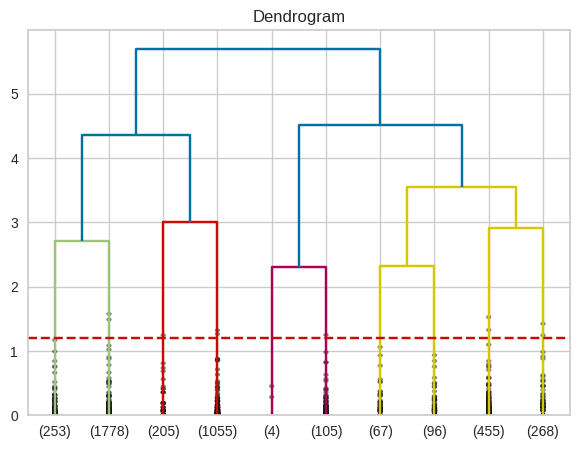

In [35]:
hc_complete = linkage(scaled_df, "complete")
plt.figure(figsize=(7, 5))
plt.title("Dendrogram")
dend = dendrogram(hc_complete,
                  truncate_mode="lastp",
                  p=10,
                  show_contracted=True,
                  leaf_font_size=10)
plt.axhline(y=1.2, color="r", linestyle="--")
plt.show()

In [36]:
hc = AgglomerativeClustering(n_clusters=6)
segments = hc.fit_predict(scaled_df)
rfm["Hierarchi_Segments"] = segments

In [37]:
rfm.groupby("Hierarchi_Segments").agg({"Recency":["mean", "median", "count"],
                                       "Frequency":["mean","median", "count"],
                                       "Monetary":["mean", "median", "count"]})

Recency               Frequency               \
                          mean median count       mean median count   
Hierarchi_Segments                                                    
0                    22.535519   17.0   915   8.221858    7.0   915   
1                    71.586618   60.0  1091   3.415215    3.0  1091   
2                   227.527851  220.0  1131   1.429708    1.0  1131   
3                    13.238095   13.0   462   2.051948    2.0   462   
4                    55.176030   53.5   534   1.000000    1.0   534   
5                     5.111111    5.0   153  21.379085   19.0   153   

                       Monetary                  
                           mean    median count  
Hierarchi_Segments                               
0                   3183.448678  2342.570   915  
1                   1354.287214   940.860  1091  
2                    474.458046   301.650  1131  
3                    654.599545   498.725   462  
4                    413.073933   281.320   534  
5                   8880.058889  7637.560   153